In [ ]:
# VAR 모형 : 다변량 선형회귀 모형
# 1. 정상성 데이터 필요 - 정상성 데이터
# 2. Granger 인과관계 - 정상성 데이터
# 3. 공적분(Cointegration) - 비정상성 데이터 입력

In [40]:
import yfinance as yf
import pmdarima as pm
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pmdarima.arima import ndiffs
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VECM

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.api import VAR


In [2]:
# MacOS - 한글 폰트
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False


In [3]:
# 데이터 수집(시가총액 10위)
stocks = ['삼성전자','현대차', 'POSCO', '현대모비스', '한국전력','SK하이닉스', '신한지주', 'LG화학', '삼성생명', 'NAVER']
ticker = ['005930', '005380', '005490', '012330', '015760', '000660', '055550', '051915', '032830', '035420']
st = {}

for i, t in enumerate(ticker):
    symbol = t+'.KS'
    data = yf.download(symbol , '2009-01-01', '2019-12-31')
    st[stocks[i]] = data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [22]:
var_df = pd.DataFrame()
var_df['삼성전자'] = st['삼성전자']['Adj Close']

# 대차잔고 데이터 수집
df = pd.read_excel('./대차잔고.xlsx', names=['Date', '체결(주수)', '상환(주수)', '잔고', '금액'])
df = df[3:-2].reset_index(drop=True)
df['Date'] = df['Date'].apply(pd.to_datetime)
df.set_index('Date', inplace=True)

var_df['대차잔고'] = df['금액'].str.replace(',', '').astype(float) * 1000000000

# 환율 가져오기
import FinanceDataReader as fdr
#원달러환율(USD/KRW)
df = fdr.DataReader('USD/KRW', "2009-01-01", "2019-12-31")
var_df['환율'] = df['Close']

# 구리 데이터 수집
df = fdr.DataReader("HG=F", "2009-01-01", "2019-12-31")
var_df['구리'] = df['Close']
df.head()

# 신용스프레드 = 국채3년물 - 회사채3년물bb(-) (일자별로)
df = pd.read_csv('./시장금리(일별)_04175822.csv', names=['국고채(3년)', '회사채(3년, BBB-)'])
df = df[1:]
df.index = pd.to_datetime(df.index)
df = df.astype(float)

df['신용스프레드'] = df['회사채(3년, BBB-)'] - df['국고채(3년)']
var_df['신용스프레드'] = df['신용스프레드']
var_df['국채'] = df['국고채(3년)']
df.head()

# 나스닥 / S&P 500

df_nas = fdr.DataReader('IXIC', '2009-01-01', '2019-12-31')
df_sp = fdr.DataReader('S&P500', '2009-01-01', '2019-12-31')

var_df['나스닥'] = df_nas['Close']
var_df['S&P500'] = df_sp['Close']
print(df_nas.head())
print(df_sp.head())


/opt/homebrew/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


                   Open         High          Low        Close      Volume
Date                                                                      
2009-01-02  1578.869995  1636.030029  1571.979980  1632.209961  1438410000
2009-01-05  1621.479980  1640.459961  1604.630005  1628.030029  1816580000
2009-01-06  1642.369995  1665.630005  1636.250000  1652.380005  2137640000
2009-01-07  1621.630005  1625.369995  1588.199951  1599.060059  2020170000
2009-01-08  1590.250000  1617.010010  1584.280029  1617.010010  1968160000
                  Open        High         Low       Close      Volume
Date                                                                  
2009-01-02  902.989990  934.729980  899.349976  931.799988  4048270000
2009-01-05  929.169983  936.630005  919.530029  927.450012  5413910000
2009-01-06  931.169983  943.849976  927.280029  934.700012  5392620000
2009-01-07  927.450012  927.450012  902.369995  906.650024  4704940000
2009-01-08  905.729980  910.000000  896.809998  9

In [6]:
var_df.head()

,삼성전자,대차잔고,환율,구리,신용스프레드,국채,나스닥,S&P500
Date,,,,,,,,
2009-01-02,7192.034180,1.101600e+13,1322.500000,1.4440,8.62,3.42,1632.209961,931.799988
2009-01-05,7283.844727,1.286200e+13,1307.800049,1.4420,8.52,3.35,1628.030029,927.450012
2009-01-06,7620.496582,1.321200e+13,1304.400024,1.5660,8.51,3.34,1652.380005,934.700012
2009-01-07,8018.351074,1.379100e+13,1301.000000,1.4945,8.45,3.45,1599.060059,906.650024
2009-01-08,7773.516602,1.361200e+13,1330.400024,1.4630,8.44,3.26,1617.010010,909.729980


In [1]:
var_df.plot()

NameError: name 'var_df' is not defined

In [131]:
df = var_df.copy()
df = df[1:]
df = df.fillna(method='ffill')

/var/folders/1s/73zrjgnx2w19qtc6h3mxcwxh0000gn/T/ipykernel_8552/235884001.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [24]:
df.isna().sum()

삼성전자      0
대차잔고      0
환율        0
구리        0
신용스프레드    0
국채        0
나스닥       0
S&P500    0
dtype: int64

In [132]:
# 1. 단위근 검정

# adf 검정
for i in df:
    result = adfuller(df[i])
    if result[1] >= 0.05:
        # 차분 진행
        n = ndiffs(df[i])
        df[i] = df[i].diff(n)
df.dropna(inplace=True)
for j in df:
    result = adfuller(df[j])
    print(result[1])

8.639174725711054e-21
0.0
0.0030826094558552156
0.0
3.111923285455188e-06
5.348717691148083e-21
0.0
0.0


In [37]:
# 2. 그랜저 인과검정 
# Y를 예측하기 위해서 Y의 과거치와 함께 변수 X를 추가할 경우 Y 예측력이 향상되면 
# 변수 X는 변수 Y에 대한 그랜저 인과관계를 가진다.

result1 = grangercausalitytests(df[['삼성전자', '환율']], maxlag=2)
result2 = grangercausalitytests(df[['환율', '삼성전자']], maxlag=4)
print(result1, result2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4750  , p=0.0345  , df_denom=2712, df_num=1
ssr based chi2 test:   chi2=4.4799  , p=0.0343  , df=1
likelihood ratio test: chi2=4.4763  , p=0.0344  , df=1
parameter F test:         F=4.4750  , p=0.0345  , df_denom=2712, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9374  , p=0.0532  , df_denom=2709, df_num=2
ssr based chi2 test:   chi2=5.8856  , p=0.0527  , df=2
likelihood ratio test: chi2=5.8792  , p=0.0529  , df=2
parameter F test:         F=2.9374  , p=0.0532  , df_denom=2709, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.7150 , p=0.0000  , df_denom=2712, df_num=1
ssr based chi2 test:   chi2=18.7357 , p=0.0000  , df=1
likelihood ratio test: chi2=18.6713 , p=0.0000  , df=1
parameter F test:         F=18.7150 , p=0.0000  , df_denom=2712, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=16.0097 , p=0.

In [38]:
# 3. 공적분 검정

sm.tsa.coint(df['환율'], df['삼성전자']) 

(-3.841659204521251,
 0.01191758818714077,
 array([-3.9004784 , -3.33838142, -3.04601251]))

In [41]:
vecm_model = VECM(df[['환율', '삼성전자']], k_ar_diff=1)

# 모델 적합
vecm_result = vecm_model.fit()

# 모델 요약 정보 출력
print(vecm_result.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation 환율
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.환율         -0.2238      0.019    -11.904      0.000      -0.261      -0.187
L1.삼성전자        0.0005      0.000      1.147      0.251      -0.000       0.001
Det. terms outside the coint. relation & lagged endog. parameters for equation 삼성전자
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.환율         -0.9246      0.870     -1.063      0.288      -2.630       0.781
L1.삼성전자        0.0381      0.019      1.976      0.048       0.000       0.076
                 Loading coefficients (alpha) for equation 환율                 
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [59]:
result_fitted

array([[  19.61769078, 1300.71839562],
       [ -30.74832495, 1324.25657322],
       [   1.9589483 , 1347.64096575],
       ...,
       [  18.51823721, 1162.37732713],
       [  45.1227596 , 1159.57329249],
       [  38.22608467, 1157.66053457]])

[ 9.77391072 -9.22786019  9.99055043 11.15374585 10.26870893 10.18642947
 10.22993532 10.23443179 10.23247917 10.23219941 10.23229428 10.2323088
 10.23230468 10.23230383 10.23230403 10.23230407 10.23230407 10.23230406
 10.23230406 10.23230406 10.23230406 10.23230406 10.23230406 10.23230406
 10.23230406 10.23230406 10.23230406 10.23230406 10.23230406 10.23230406
 10.23230406 10.23230406 10.23230406 10.23230406 10.23230406 10.23230406
 10.23230406 10.23230406 10.23230406 10.23230406 10.23230406 10.23230406
 10.23230406 10.23230406 10.23230406 10.23230406 10.23230406 10.23230406
 10.23230406 10.23230406 10.23230406 10.23230406 10.23230406 10.23230406
 10.23230406 10.23230406 10.23230406 10.23230406 10.23230406 10.23230406
 10.23230406 10.23230406 10.23230406 10.23230406 10.23230406 10.23230406
 10.23230406 10.23230406 10.23230406 10.23230406 10.23230406 10.23230406
 10.23230406 10.23230406 10.23230406 10.23230406 10.23230406 10.23230406
 10.23230406 10.23230406 10.23230406 10.23230406 10.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


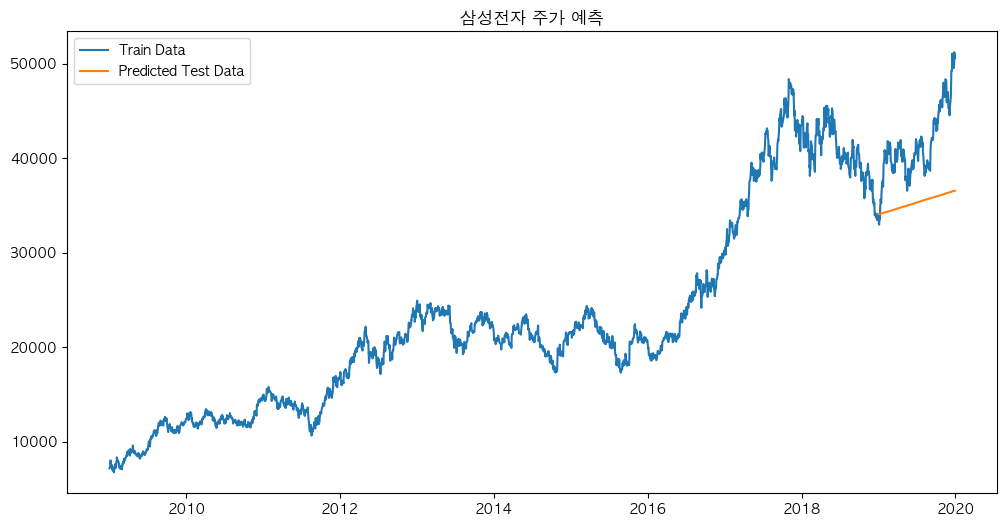

RMSE: 35259.189745693446


In [115]:
import pandas as pd
from statsmodels.tsa.api import VECM
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

# 데이터 불러오기 (가정)
# df는 삼성전자 주가와 환율을 포함하는 데이터프레임이라고 가정합니다.
# df의 인덱스는 시계열 데이터의 날짜여야 합니다.


# 데이터 분할 (가정)
train_data = df['2009-01-01':'2018-12-31']
test_data = df['2019-01-01':]


# VECM 모델 구축
model = VECM(train_data[['삼성전자', '환율']], k_ar_diff=1)
result = model.fit()

# 모델 훈련
result_fitted = result.fittedvalues

# 예측
forecast_steps = len(test_data)
forecast_diff = result.predict(steps=forecast_steps)
print(forecast_diff[:,0])

# 차분을 원래 스케일로 되돌리기
forecast_samsung = np.r_[var_df['삼성전자']['2009-01-01':'2018-12-31'].iloc[-1],
                            forecast_diff[:, 0]].cumsum()[1:]

forecast_samsung = pd.DataFrame(forecast_samsung, index=test_data.index)
# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(var_df['삼성전자'], label='Train Data')
plt.plot(forecast_samsung, label='Predicted Test Data')
plt.legend()
plt.title('삼성전자 주가 예측')
plt.show()

# 정확도 측정 (예시로 평균 제곱근 오차 사용)
rmse = sqrt(mean_squared_error(test_data['삼성전자'], forecast_samsung))
print(f'RMSE: {rmse}')



In [171]:
import pandas as pd
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

# 데이터 불러오기 (가정)
# df는 삼성전자 주가와 환율을 포함하는 데이터프레임이라고 가정합니다.
# df의 인덱스는 시계열 데이터의 날짜여야 합니다.


# 데이터 분할 (가정)
train_data = df['2009-01-01':'2018-12-31']
test_data = df['2019-01-01':]


# VAR 모델 구축
model = VAR(train_data[['삼성전자', '환율']])
result = model.fit()

# 모델 훈련
result_fitted = result.fittedvalues

# 예측

forecast_steps = len(test_data)

# 삼성전자 주가만 예측
forecast = result.forecast(y=train_data['삼성전자'].values,steps=forecast_steps)

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(train_data['삼성전자'], label='Train Data')
plt.plot(test_data['삼성전자'], label='Test Data')
plt.plot(forecast['삼성전자'], label='Predicted Test Data')
plt.legend()
plt.title('삼성전자 주가 예측')
plt.show()

# 정확도 측정 (예시로 평균 제곱근 오차 사용)
rmse = sqrt(mean_squared_error(test_data['삼성전자'], forecast['삼성전자']))
print(f'RMSE: {rmse}')


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ValueError: could not broadcast input array from shape (2,2) into shape (2,)